<a href="https://colab.research.google.com/github/phelipe-sb/Rain-Prediction/blob/main/Extract_Pickle_File_from_BigQuery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **1. Get Data from BigQuery**

In [1]:
from google.cloud import bigquery
from google.oauth2 import service_account
import numpy as np
import pandas as pd

In [2]:
# Projett credentials with account service
path = '/content/Weather Project-6fa8e059f642.json'

In [3]:
# Credentials
credentials = service_account.Credentials.from_service_account_file(path)
project_id = credentials.project_id
client = bigquery.Client(project=project_id, credentials=credentials)

In [4]:
# SQL Query that will run in BQ
query_string = """
SELECT *
FROM (SELECT *
            , ROW_NUMBER() OVER(PARTITION BY last_updated, city ORDER BY last_updated, city) AS row_num
            FROM `weather-project-305419.Daily_Weather.Weather-Info`) as row_weather
WHERE row_num = 1
"""

In [5]:
# Transform sql query results in a pandas dataframe
df = (
    client.query(query_string)
    .result()
    .to_dataframe()
)
df.head()

,last_updated_epoch,last_updated,temp_c,temp_f,is_day,condition,wind_mph,wind_kph,wind_degree,wind_dir,pressure_mb,pressure_in,precip_mm,precip_in,humidity,cloud,feelslike_c,feelslike_f,vis_km,vis_miles,uv,gust_mph,gust_kph,city,extraction_date,row_num
0,1619146800,2021-04-23 00:00,16.4,61.5,0,Partly cloudy,4.9,7.9,134,SE,1018.0,30.5,0.0,0.0,88,60,16.4,61.5,10.0,6.0,1.0,5.6,9.0,Sao Paulo,None,1
1,1619152200,2021-04-23 05:30,4.0,39.2,0,Clear,0.0,0.0,75,ENE,1029.0,30.9,0.0,0.0,87,0,2.2,35.9,10.0,6.0,1.0,5.1,8.3,London,None,1
2,1619244000,2021-04-24 07:00,7.1,44.8,1,Partly cloudy,6.5,10.4,71,ENE,1028.0,30.8,0.0,0.0,80,22,5.1,41.2,10.0,6.0,1.0,8.9,14.4,London,None,1
3,1619308800,2021-04-24 21:00,25.1,77.2,0,Partly cloudy,2.7,4.3,208,SSW,1013.0,30.4,0.0,0.0,66,16,27.1,80.8,10.0,6.0,1.0,4.3,6.8,Carapicuiba,None,1
4,1619328600,2021-04-25 02:30,20.1,68.2,0,Partly cloudy,2.2,3.6,52,NE,1014.0,30.4,0.0,0.0,89,17,20.1,68.2,10.0,6.0,1.0,2.5,4.0,Sao Paulo,None,1


In [6]:
# Saving in a pickle file so we don't need query in database again
import pickle
df.to_pickle("weather_data_08-09-2021")

### **2. Analysis/Transformations**

In [7]:
# Open pickle file
file = open('weather_data_08-09-2021', 'rb')
df = pickle.load(file)

In [8]:
cidades = ['Paris', 'Sao Paulo', 'Carapicuiba', 'New York', 'Otawwa', 'London', 'Rome', 'Moscow'
        , 'Hong Kong', 'Beijing']
df = df.loc[df['city'].isin(cidades)]
df['last_updated'] = pd.to_datetime(df['last_updated'])
df.shape

(45648, 26)

In [9]:
# Drop useless columns for analysis
df = df.drop(columns=['row_num', 'last_updated_epoch', 'extraction_date'])
df = df.dropna()
# number of rows and columns
print(df.shape, df['city'].unique())

(45648, 23) ['Sao Paulo' 'London' 'Carapicuiba' 'New York' 'Paris' 'Hong Kong' 'Rome'
 'Moscow' 'Beijing']


In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

In [11]:
# Target: Predict condition (that means wether is raining or not) 
df['condition'].unique()

array(['Partly cloudy', 'Clear', 'Overcast', 'Sunny', 'Cloudy',
       'Light rain', 'Mist', 'Patchy rain possible', 'Light rain shower',
       'Light drizzle', 'Fog', 'Torrential rain shower',
       'Thundery outbreaks possible', 'Heavy rain',
       'Moderate rain at times', 'Moderate or heavy rain shower',
       'Moderate rain', 'Patchy light rain with thunder',
       'Patchy light rain', 'Light snow',
       'Moderate or heavy rain with thunder',
       'Moderate or heavy snow with thunder',
       'Moderate or heavy snow showers'], dtype=object)

We need to resume this bunch of conditions and define our target class

In [12]:
# This conditions means that it's raining in the moment
raining_list = ['Light rain', 'Light rain shower', 'Light drizzle', 'Heavy rain', 'Moderate rain', 'Patchy light rain with thunder'
            , 'Moderate or heavy rain shower', 'Patchy light rain', 'Torrential rain shower', 'Moderate rain at times'
            , 'Moderate or heavy rain with thunder']

In [13]:
# Creating the target variable
df['target'] = df['condition'].apply(lambda x: 1 if x in raining_list else 0)
df['target'].unique()

array([0, 1])

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45648 entries, 0 to 46671
Data columns (total 24 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   last_updated  45648 non-null  datetime64[ns]
 1   temp_c        45648 non-null  object        
 2   temp_f        45648 non-null  object        
 3   is_day        45648 non-null  object        
 4   condition     45648 non-null  object        
 5   wind_mph      45648 non-null  object        
 6   wind_kph      45648 non-null  object        
 7   wind_degree   45648 non-null  object        
 8   wind_dir      45648 non-null  object        
 9   pressure_mb   45648 non-null  object        
 10  pressure_in   45648 non-null  object        
 11  precip_mm     45648 non-null  object        
 12  precip_in     45648 non-null  object        
 13  humidity      45648 non-null  object        
 14  cloud         45648 non-null  object        
 15  feelslike_c   45648 non-null  object

In [15]:
# Create a list with columns to be converted
float_list = list()
for column_name in df.drop(columns='target').columns:
  if str(df[f'{column_name}'][0]).replace(".", "").replace("-", "").isnumeric() == True:
    float_list.append(column_name)

In [16]:
# function to convert columns to float
def to_float(df):
  for column in df.columns:
    if column in float_list:
      df[f'{column}'] = df[f'{column}'].astype("float")
  return df.info()

In [17]:
to_float(df)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45648 entries, 0 to 46671
Data columns (total 24 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   last_updated  45648 non-null  datetime64[ns]
 1   temp_c        45648 non-null  float64       
 2   temp_f        45648 non-null  float64       
 3   is_day        45648 non-null  float64       
 4   condition     45648 non-null  object        
 5   wind_mph      45648 non-null  float64       
 6   wind_kph      45648 non-null  float64       
 7   wind_degree   45648 non-null  float64       
 8   wind_dir      45648 non-null  object        
 9   pressure_mb   45648 non-null  float64       
 10  pressure_in   45648 non-null  float64       
 11  precip_mm     45648 non-null  float64       
 12  precip_in     45648 non-null  float64       
 13  humidity      45648 non-null  float64       
 14  cloud         45648 non-null  float64       
 15  feelslike_c   45648 non-null  float6

percentage of target == 1 is: 10.0%


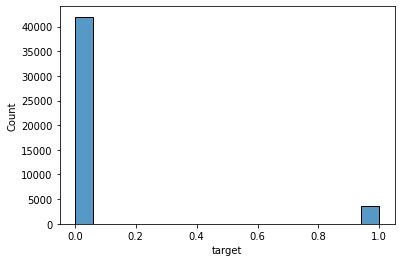

In [18]:
# Target Variable Ocurrency
percent = str(round(sum(df['target'])/len(df['target']), 1)*100) + '%'
print(f'percentage of target == 1 is: {percent}')
sns.histplot(data=df['target'])

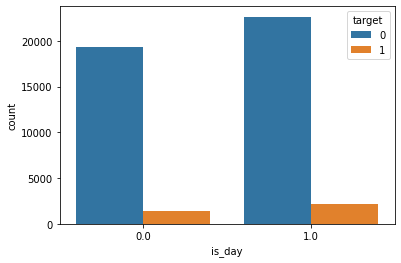

In [19]:
sns.countplot(x=df['is_day'], hue=df['target'])

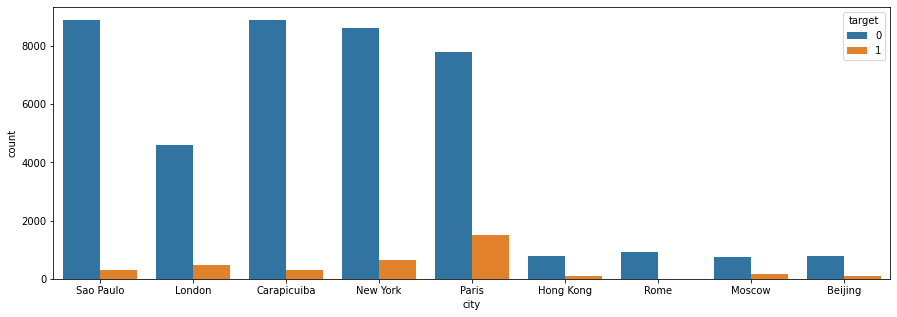

In [20]:
plt.figure(figsize=(15, 5))
ax = sns.countplot(x=df['city'], hue=df['target'])

<Figure size 720x360 with 0 Axes>

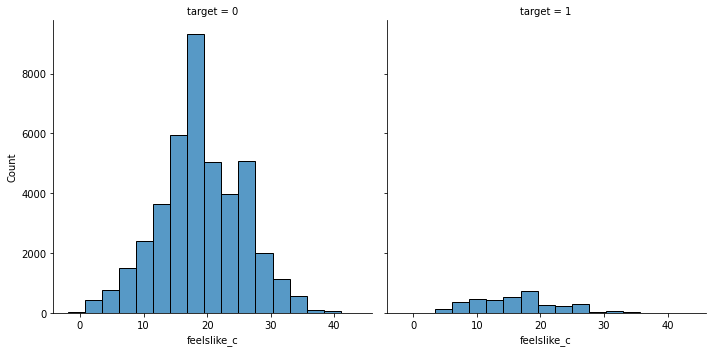

In [21]:
plt.figure(figsize=(10, 5))
ax = sns.displot(x=df['feelslike_c'], bins='sturges', col=df['target'])

<Figure size 720x360 with 0 Axes>

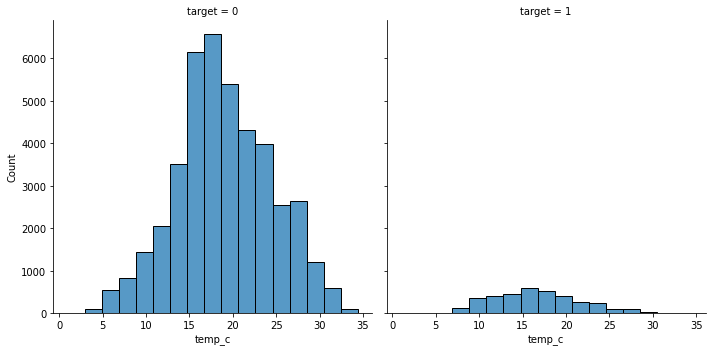

In [22]:
plt.figure(figsize=(10, 5))
ax = sns.displot(x=df['temp_c'], bins='sturges', col=df['target'])

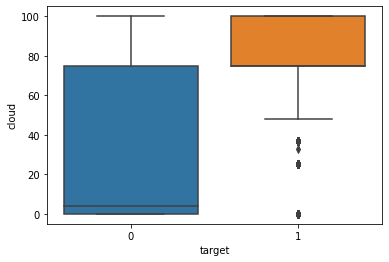

In [23]:
sns.boxplot(x=df['target'], y=df['cloud'])

In [24]:
# Our goal is to predict weather is going to rain or not based on the last register
# Now we're going to split the data
train_df = df[['last_updated', 'city', 'temp_c', 'is_day', 'condition', 'wind_mph', 'wind_degree'
          , 'pressure_mb', 'precip_mm', 'humidity', 'cloud', 'feelslike_c', 'vis_km', 'uv'
          , 'gust_kph', 'target']]

In [30]:
train_df = train_df.sort_values(by=['city', 'last_updated']).reset_index().drop(columns='index')